## Import libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk import FreqDist
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings

In [ ]:
warnings.filterwarnings("ignore")

## Load data

In [2]:
df = pd.read_csv("./Data/IMDB Dataset.csv")
df.head()

,review_es,review_en,review_fr,sentiment
0,Uno de los otros críticos ha mencionado que de...,One of the other reviewers has mentioned that ...,L'un des autres critiques a mentionné qu'après...,positive
1,Una pequeña pequeña producción.La técnica de f...,A wonderful little production. The filming tec...,Une merveilleuse petite production. La techniq...,positive
2,Pensé que esta era una manera maravillosa de p...,I thought this was a wonderful way to spend ti...,J'ai pensé que c'était une merveilleuse façon ...,positive
3,"Básicamente, hay una familia donde un niño peq...",Basically there's a family where a little boy ...,"En gros, il y a une famille où un petit garçon...",negative
4,"El ""amor en el tiempo"" de Petter Mattei es una...","Petter Mattei's ""Love in the Time of Money"" is...","""L'amour au temps de l'argent"" de Petter Matte...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_es  50000 non-null  object
 1   review_en  50000 non-null  object
 2   review_fr  50000 non-null  object
 3   sentiment  50000 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB


In [4]:
df['es'] = 'es'
df['en'] = 'en'
df['fr'] = 'fr'
df_es = df[['review_es','es']]
df_en = df[['review_en','en']]
df_fr = df[['review_fr','fr']]
df_es.columns = ['review','language']
df_en.columns = ['review','language']
df_fr.columns = ['review','language']
df = pd.concat([df_es, df_en, df_fr], ignore_index=True)
df = df.sample(frac=1, random_state=42)
df.head()

,review,language
59770,I am from Romania ... and for that i apologize...,en
21362,Aquellos revisores que se han quejado de que e...,es
127324,"Avec ""King of the Rocket Men"", cela était enco...",fr
140509,"En lisant le scénario en ligne, j'ai pensé que...",fr
144297,Ruth Gordon est l'un des tueurs les plus sympa...,fr


## Process data

In [13]:
def cleaning_texts(texts):
    clean_texts = []
    for text in texts:
        text = re.sub(r'[^a-zA-Záéíóúüñàâäéèêëîïôœùûç\']', ' ', text)
        text = text.lower().strip()
        text = re.sub(r'\s+', ' ', text)
        clean_texts.append(text)
    return clean_texts

In [14]:
def tokenize_texts(texts):
    tokenized_texts = []
    for text in texts:
        tokenized_texts.append(text.split())
    return tokenized_texts

In [15]:
def remove_stopwords(texts):
    texts_without_stopwords = []
    nltk.download("stopwords")
    stop_words = set(stopwords.words("spanish")) | set(stopwords.words("english")) | set(stopwords.words("french"))
    for text in texts:
        texts_without_stopwords.append([word for word in text if word not in stop_words])
    return texts_without_stopwords

In [34]:
def vectorize_texts(texts, vocabulary):
    vectoriced_texts = []
    for i, text in enumerate(texts):
        vectoriced_text = []
        for j, word in enumerate(text):
            if word in vocabulary:
                vectoriced_text.append(vocabulary[word]) 
            else:
                vectoriced_text.append(0) 
        vectoriced_texts.append(vectoriced_text)
    return vectoriced_texts

In [17]:
texts = df['review'].to_list()
clean_texts = cleaning_texts(texts)
tokenized_texts = tokenize_texts(clean_texts)
tokenized_texts = remove_stopwords(tokenized_texts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hermann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Word Cloud

In [22]:
corpus = ' '.join(df['review'].to_list())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

In [30]:
corpus = ' '.join(' '.join(text) for text in tokenized_texts)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

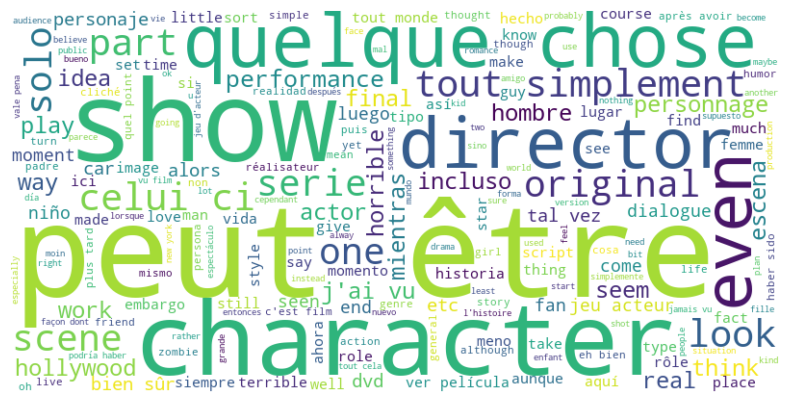

In [31]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Top words

In [32]:
words = []
for text in tokenized_texts:
    words.extend(text)
frequency = FreqDist(words)
top_20 = frequency.most_common(20)
words, freq = zip(*top_20)

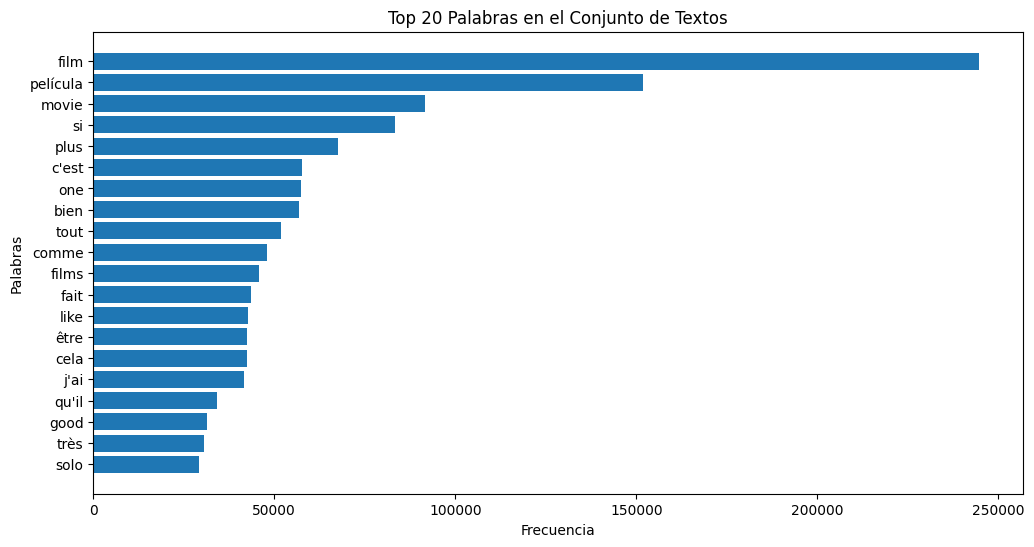

In [33]:
plt.figure(figsize=(12, 6))
plt.barh(words, freq)
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Top 20 Palabras en el Conjunto de Textos')
plt.gca().invert_yaxis() 
plt.show()

## Word2Vec Model

In [23]:
model_word2vec = Word2Vec(tokenized_texts, vector_size=50, window=10, min_count=10, workers=4)
model_word2vec.train(tokenized_texts,total_examples=model_word2vec.corpus_count, epochs=20)
model_word2vec.save("./Models/Word2Vec_language_detector")

## Vectorize texts

In [27]:
model_word2vec = Word2Vec.load("./Models/Word2Vec_language_detector")
vocabulary = model_word2vec.wv.key_to_index

In [33]:
maxlen = 150
max_words = len(vocabulary)

vectorized_texts = vectorize_texts(tokenized_texts, vocabulary)
X = pad_sequences(vectorized_texts, maxlen=maxlen)
y = df['language'].apply(lambda x : [1,0,0] if x == 'es' 
                         else ([0,1,0] if x == 'en' else [0,0,1] )).to_list()
y = np.array(y)

## Split dataset into training and test

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build embedding matrix

In [37]:
embedding_matrix = np.zeros((max_words, 50))
for word, i in vocabulary.items():
    if i < max_words:
        if word in vocabulary:
            embedding_matrix[i] = model_word2vect.wv[word]

## Plot confusion matrix

In [38]:
def plot_confusion_matrix(y_true, y_pred):
    
    conf_matrix = confusion_matrix(y_true, y_pred) 
    
    fig, ax = plt.subplots(figsize=(3, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.8)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
 
    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

## MLP Model

In [39]:
model_mlp = Sequential()
model_mlp.add(Input(shape=(maxlen,)))
model_mlp.add(Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False))
model_mlp.add(Flatten())
model_mlp.add(Dense(units=256, activation='relu'))
model_mlp.add(Dense(units=3, activation='softmax'))

In [40]:
model_mlp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           4070800   
                                                                 
 flatten (Flatten)           (None, 7500)              0         
                                                                 
 dense (Dense)               (None, 256)               1920256   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 5,991,827
Trainable params: 1,921,027
Non-trainable params: 4,070,800
_________________________________________________________________


In [41]:
checkpoint = ModelCheckpoint(
    './Models/model_mlp.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_mlp_history = model_mlp.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

Epoch 1/10
750/750 [==============================] - 39s 51ms/step - loss: 0.0729 - accuracy: 0.9854 - val_loss: 0.0384 - val_accuracy: 0.9877
Epoch 2/10
750/750 [==============================] - 28s 37ms/step - loss: 0.0328 - accuracy: 0.9879 - val_loss: 0.0360 - val_accuracy: 0.9877
Epoch 3/10
750/750 [==============================] - 26s 35ms/step - loss: 0.0303 - accuracy: 0.9878 - val_loss: 0.0380 - val_accuracy: 0.9874
Epoch 4/10
750/750 [==============================] - 27s 36ms/step - loss: 0.0269 - accuracy: 0.9887 - val_loss: 0.0391 - val_accuracy: 0.9859
Epoch 5/10
750/750 [==============================] - 27s 36ms/step - loss: 0.0247 - accuracy: 0.9892 - val_loss: 0.0426 - val_accuracy: 0.9855
Epoch 6/10
750/750 [==============================] - 26s 35ms/step - loss: 0.0222 - accuracy: 0.9901 - val_loss: 0.0454 - val_accuracy: 0.9863
Epoch 7/10
750/750 [==============================] - 25s 33ms/step - loss: 0.0204 - accuracy: 0.9905 - val_loss: 0.0548 - val_accuracy:

In [42]:
model_mlp = load_model("./Models/model_mlp.h5")
y_pred_mlp = np.argmax(model_mlp.predict(X_test), axis=1)
y_test_ = np.argmax(y_test, axis=1)

938/938 [==============================] - 4s 4ms/step


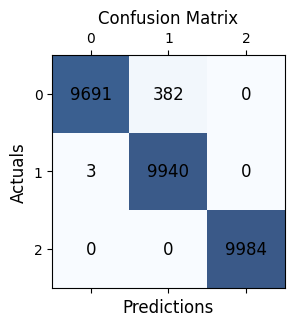

In [43]:
plot_confusion_matrix(y_test_, y_pred_mlp)

In [45]:
print(classification_report(y_test_,y_pred_mlp))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     10073
           1       0.96      1.00      0.98      9943
           2       1.00      1.00      1.00      9984

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



## Model LSTM

In [46]:
model_lstm = Sequential()
model_lstm.add(Input(shape=(maxlen,)))
model_lstm.add(Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False))
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model_lstm.add(Flatten())
model_lstm.add(Dense(units=256, activation='relu'))
model_lstm.add(Dense(units=3, activation='softmax'))

In [47]:
model_lstm.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 50)           4070800   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              58880     
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 4,163,475
Trainable params: 92,675
Non-trainable params: 4,070,800
_______________________________________

In [48]:
checkpoint = ModelCheckpoint(
    './Models/model_lstm.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_lstm_history = model_lstm.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

Epoch 1/10
750/750 [==============================] - 285s 374ms/step - loss: 0.0444 - accuracy: 0.9851 - val_loss: 0.0348 - val_accuracy: 0.9877
Epoch 2/10
750/750 [==============================] - 235s 313ms/step - loss: 0.0334 - accuracy: 0.9881 - val_loss: 0.0347 - val_accuracy: 0.9877
Epoch 3/10
750/750 [==============================] - 288s 384ms/step - loss: 0.0327 - accuracy: 0.9881 - val_loss: 0.0351 - val_accuracy: 0.9877
Epoch 4/10
750/750 [==============================] - 284s 379ms/step - loss: 0.0311 - accuracy: 0.9881 - val_loss: 0.0357 - val_accuracy: 0.9877
Epoch 5/10
750/750 [==============================] - 287s 383ms/step - loss: 0.0288 - accuracy: 0.9880 - val_loss: 0.0390 - val_accuracy: 0.9875
Epoch 6/10
750/750 [==============================] - 292s 389ms/step - loss: 0.0260 - accuracy: 0.9882 - val_loss: 0.0415 - val_accuracy: 0.9853
Epoch 7/10
750/750 [==============================] - 313s 418ms/step - loss: 0.0234 - accuracy: 0.9890 - val_loss: 0.0443 -

In [49]:
model_lstm = load_model("./Models/model_lstm.h5")
y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)
y_test_ = np.argmax(y_test, axis=1)

938/938 [==============================] - 27s 27ms/step


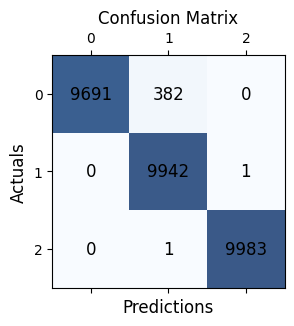

In [50]:
plot_confusion_matrix(y_test_, y_pred_lstm)

In [51]:
print(classification_report(y_test_,y_pred_lstm))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     10073
           1       0.96      1.00      0.98      9943
           2       1.00      1.00      1.00      9984

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000

